**Code Flow**

1.   Use CK+ database with expression label and AU labels - *#309 images*
2.   Process the images to obtain frontal and uniform eye distance faces - *using facemask for test*
3.   Scale the obtained images to agreed resolution without distorting aspect-ratio

---

Alternating Optimization 

4.   Use Expression-AU relationship table#2 to initialize missing AU labels as 1 or 0
5.   Extract features and textures from processed images using local binary pattern - *sklearn module*
6.   Reduce dimensionality of the data using PCA/LDA/Adaboost/Gentleboost - *planned in next iteration*
7.   Train SVM classifier with RBF kernel per Eq#21 - *L-BGFS planned in next iteration*
8.   After converging step#7, fix W using optimized values
9.   Start training again using Eq#22
10.   Find best AU config for each sample by Eq#20
11.   If Eq#20 minimized then replace AU config else don't
12.   Repeat step9-11 until all samples are best per Eq#20
13.   Repeat from step#7



In [2]:
def download_dataset_to_collab(dataset):
  '''
  Google Drive is a tag-based (also called semantic) file system, which, for example, allows a file to be in several places at the same time 
  (just by adding IDs of folders to the file's parents property)
  Hence to get the file/folder ID, navigate to the folder using browser & note the ID from URL 
  Ex: https://drive.google.com/drive/folders/1mZVxppM8dHFcoKdc9Vu9vS-n_GGnpCkO
  '''
  #Code to download files from google drive to collab using Pydrive

  !pip install -U -q PyDrive

  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  import time

  # 1. Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Auto-iterate through all files in the folder ID.
  start = time.time()
  for key, value in dataset.items():
    print("Initiating files copy from {} ...".format(key))
    file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(value)}).GetList()      #file_list = drive.ListFile({'q': "'1czmCOb4w0LiWetvQyhIxi6gGvJuAYb5F' in parents and trashed=false"}).GetList()
    for file1 in file_list:      
      file6 = drive.CreateFile({'id': file1['id']}) # Initialize GoogleDriveFile instance with file id.
      file6.GetContentFile(file1['title'])          # Download file as file1['title']
    !mkdir 'datalab/'$key                           # move the data to folder in dictionary
    !ls -l datalab/
    !mv *.png 'datalab/'$key
    !ls -l datalab/
    print("Completed files copy from {}.".format(key))

  end = time.time()                                                                
  return 'time taken:'+ str(end-start) +'seconds'

dataset = {
          #'<folder_name>':'<gdrive_folder_id>'
          'mask_images_emotion':'1p7acuIviEzK5D1-udAdConjhmF7hFJIm', 
          #'test':'1czmCOb4w0LiWetvQyhIxi6gGvJuAYb5F',
          #'train_cleaned':'1T4uCpfZueGsSUCu145FuEcPY_he6A2fQ'
          }
download_dataset_to_collab(dataset)

Initiating files copy from mask_images_emotion ...
total 0
total 5560
-rw-r--r-- 1 root root 20293 Aug 25 13:59 S005_001_00000011.png
-rw-r--r-- 1 root root 18773 Aug 25 13:58 S010_002_00000014.png
-rw-r--r-- 1 root root 16852 Aug 25 13:58 S010_004_00000019.png
-rw-r--r-- 1 root root 18118 Aug 25 13:58 S010_006_00000015.png
-rw-r--r-- 1 root root 20457 Aug 25 13:59 S011_001_00000016.png
-rw-r--r-- 1 root root 17859 Aug 25 13:59 S011_002_00000022.png
-rw-r--r-- 1 root root 18638 Aug 25 13:57 S011_003_00000014.png
-rw-r--r-- 1 root root 16102 Aug 25 13:59 S011_004_00000021.png
-rw-r--r-- 1 root root 16998 Aug 25 13:59 S011_005_00000020.png
-rw-r--r-- 1 root root 18243 Aug 25 13:59 S011_006_00000013.png
-rw-r--r-- 1 root root 21986 Aug 25 13:59 S014_001_00000029.png
-rw-r--r-- 1 root root 17401 Aug 25 13:58 S014_002_00000016.png
-rw-r--r-- 1 root root 16987 Aug 25 13:59 S014_003_00000030.png
-rw-r--r-- 1 root root 18249 Aug 25 13:58 S014_005_00000017.png
-rw-r--r-- 1 root root 15027 Aug 2

'time taken:152.328440905seconds'

In [5]:
import os
import numpy as np
#http://scikit-image.org/docs/dev/api/skimage.io.html
from skimage.io import imread
for f in os.listdir('./datalab/img'):
  opath='./datalab/img/'+str(f)
  img = np.asarray(imread(opath))/255.0
print(img.shape)

(382, 500)


In [0]:
#http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.downscale_local_mean
from skimage.transform import resize, pyramid_reduce
from skimage.io import imread
import numpy as np

#https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
def scale_img_to_sqaure(image, square_size):

    height, width = image.shape    
    if(height > width):
      differ = height
    else:
      differ = width
    differ += 4

    # square filler
    mask = np.zeros((differ, differ), dtype = "uint8")

    x_pos = int((differ - width) / 2)
    y_pos = int((differ - height) / 2)

    # center image inside the square
    mask[y_pos: y_pos + height, x_pos: x_pos + width] = image[0: height, 0: width]

    # downscale if needed
    if differ / square_size > 1:
      mask = pyramid_reduce(mask, differ / square_size)
    else:
      mask = cv2.resize(mask, (square_size, square_size), interpolation = cv2.INTER_AREA)
    return mask

i=np.asarray(imread('datalab/img/S097_001_00000021.png'))/255.0
sq = scale_img_to_sqaure(i,128)

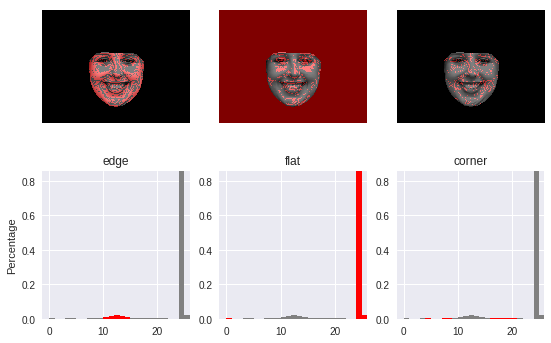

In [22]:
#http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb
import numpy as np
import matplotlib.pyplot as plt


METHOD = 'uniform'
plt.rcParams['font.size'] = 9

# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


image = data.load('/content/datalab/img/S052_004_00000033.png')
lbp = local_binary_pattern(image, n_points, radius, METHOD)


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), normed=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(ymax=np.max(counts[:-1]))
    ax.set_xlim(xmax=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')